<div align="right" style="text-align: right;"><i>Peter Norvig<br>Jotto: April 2020<br>Wordle: Jan 2022</i></div>

# Jotto and Wordle: Word Guessing Games

[Jotto](https://en.wikipedia.org/wiki/Jotto) is a word game in which a **guesser** tries to guess a secret **target** word, which is chosen from a **word list** of allowable words, in as few guesses as possible. Each guess must be one of the allowable words, and the **reply** to each guess is the number of letters in common between the guess word and the target word, regardless of the positions of the letters.   

Here is an example Jotto game, where I show the guesses, the replies, the number of remaining consistent target words, and finally the letters that matched (the matches are an aid to you, the reader; they are not known to the guesser). A **consistent target** is a word that would give the same reply to each guess as the replies actually observed.  In this game, the guesser gets to the target word, "wonky", in 7 guesses. 

    Guess 1: "stoma" Reply: 1; Consistent targets: 1118    (Matched: "o")
    Guess 2: "bairn" Reply: 1; Consistent targets: 441     (Matched: "n")
    Guess 3: "swipe" Reply: 1; Consistent targets: 197     (Matched: "w")
    Guess 4: "lurks" Reply: 1; Consistent targets: 87      (Matched: "k")
    Guess 5: "rowdy" Reply: 3; Consistent targets: 14      (Matched: "owy")
    Guess 6: "roved" Reply: 1; Consistent targets: 2       (Matched: "o")
    Guess 7: "wonky" Reply: 5; Consistent targets: 1       (Matched: "wonky")


There are several variants of Jotto; here are five key questions and my answers:

- How many letters can each word have? <br>**Five**.
- Does a guess have to be a word in the word list? <br>**Yes.**
- Can a word have repeated letters, like the "s" in "stars"? <br>**No.** Every word must have 5 different letters.
- What if the reply is "5", but the guess is not the target?<br>**Not allowed**. No two words in the word list may have the same set of five letters.<br>(For example, only one of the anagrams apers/pares/parse/pears/reaps/spare/spear is allowed.)
- Who chooses the target word? <br>**Random chance**. Jotto is sometimes a two-person game where the chooser is an adversary, but not here.

# Jotto Preliminaries

First off, some Python basics: Import some modules and define the basic types `Word`, `Score`, and `Reply`:

In [1]:
from typing      import List, Tuple, Dict, Union, Counter, Callable, Iterable
from dataclasses import dataclass
from statistics  import mean, median, stdev
from collections import defaultdict
from math        import log2
import random 
import matplotlib.pyplot as plt

Word  = str # A word is a lower-case string of five different letters
Score = int # A score is the number of guesses it took to get the target word
Reply = int # A reply is the number of letters in common between guess and target words

random.seed(42) # For reproducibility

We can make a Jotto word list by:
- Starting with a file containing a list of words.
- Discarding the ones that don't have 5 distinct letters.
- Putting the rest into a dict of anagrams keyed by the set of letters.
- Keeping only one word for each anagram.

In [2]:
def read_words(filename) -> List[Word]: return open(filename).read().split()

def allowable(words) -> List[Word]:
    """Build a list of allowable Jotto words from an iterable of words."""
    anagrams = {frozenset(w): w for w in words if len(w) == 5 == len(set(w))}
    return list(anagrams.values())

The [Stanford GraphBase project](https://www-cs-faculty.stanford.edu/~knuth/sgb.html) has a nice list of five-letter words, [sgb-words.txt](sgb-words.txt):

In [3]:
! [ -e sgb-words.txt ] || curl -O https://norvig.com/ngrams/sgb-words.txt
    
wordlist = allowable(read_words('sgb-words.txt'))

len(wordlist)

2845

We see there are 2,845 allowable Jotto words in [sgb-words.txt](sgb-words.txt).

# Playing Jotto

The function `play` will play a game of Jotto and return the score (the number of guesses). The  arguments are:
- `guesser`: a `callable` (e.g., a function) that should return the guess to make. The guesser is passed two arguments: 
  - The reply to the previous guess.
  - A list of the words that are consistent with all the guesses made so far. 
<br>(If the guesser wants to keep track of all the guesses made so far, or all the words in the word list, it can.)
- `target`: The target word. If none is given, the target word is chosen at random from the wordlist.
- `wordlist`: The list of allowable words.
- `verbose`: Unless false, print a message for each guess.

Two corner cases: 
1. If the guesser improperly guesses a non-word, the reply is `None`. 
2. To prevent an infinite loop, the worst score you can get is the number of words in the wordlist.

In [4]:
Guesser = Callable[[Reply, List[Word]], Word]

def play(guesser: Guesser, target=None, wordlist=wordlist, verbose=True) -> Score:
    """The number of guesses it take for `guesser` to guess the Jotto word,
    which is given by `target` or selected from the words in `wordlist`?"""
    target  = target or random.choice(wordlist) # Choose a random target if none was given
    targets = wordlist      # The targets that are consistent with all replies
    reply   = None          # For the first guess, there is no previous reply
    N       = len(wordlist)
    for turn in range(1, N + 1):
        guess = guesser(reply, targets)
        reply = reply_for(guess, target) if guess in wordlist else None
        targets = [t for t in targets if reply_for(guess, t) == reply]
        if verbose: 
            print(f'Guess {turn}: "{guess}" Reply: {reply}; Consistent targets: {len(targets)}')
        if guess == target or turn == N:  
            return turn
                         
def reply_for(guess, target) -> Reply: 
    "The number of letters in common between the target and guess"
    return len(set(target).intersection(guess))

To play a game, we will need a guesser. Here are two simple ones:


In [5]:
def human_guesser(reply, targets) -> Word: 
    """Ask a human to make a guess."""
    return input(f'Reply was {reply}. Your guess? ')

def random_guesser(reply, targets) -> Word: 
    """Choose a guess at random from the consistent targets."""
    return random.choice(targets)

# Sample Jotto Games

Here is the `random_guesser` in action:

In [6]:
play(random_guesser)

Guess 1: "strop" Reply: 3; Consistent targets: 322
Guess 2: "party" Reply: 1; Consistent targets: 112
Guess 3: "obits" Reply: 3; Consistent targets: 44
Guess 4: "sloth" Reply: 2; Consistent targets: 12
Guess 5: "brows" Reply: 2; Consistent targets: 5
Guess 6: "pious" Reply: 4; Consistent targets: 4
Guess 7: "pions" Reply: 4; Consistent targets: 3
Guess 8: "dipso" Reply: 5; Consistent targets: 1


8

In [7]:
play(random_guesser)

Guess 1: "carpy" Reply: 0; Consistent targets: 602
Guess 2: "litho" Reply: 2; Consistent targets: 249
Guess 3: "loved" Reply: 0; Consistent targets: 21
Guess 4: "fugit" Reply: 2; Consistent targets: 7
Guess 5: "skint" Reply: 1; Consistent targets: 1
Guess 6: "thumb" Reply: 5; Consistent targets: 1


6

In [8]:
play(random_guesser, target='world')

Guess 1: "thous" Reply: 1; Consistent targets: 1141
Guess 2: "vocal" Reply: 2; Consistent targets: 340
Guess 3: "snack" Reply: 0; Consistent targets: 46
Guess 4: "vigor" Reply: 2; Consistent targets: 19
Guess 5: "oxlip" Reply: 2; Consistent targets: 10
Guess 6: "roble" Reply: 3; Consistent targets: 4
Guess 7: "world" Reply: 5; Consistent targets: 1


7

#  Partitioning Target Words

A key idea in guessing is to reduce the number of consistent targets. When there is a single consistent target left, the game is over. We can think of a guess as **partitioning** the consistent targets into different **branches** of a tree, each branch corresponding to a different reply:

In [9]:
def partition(guess, targets) ->  Dict[Reply, List[str]]:
    """A guess partition targets by the possible replies to guess: {reply: [word, ...]}."""
    branches = defaultdict(list)
    for target in targets:
        branches[reply_for(guess, target)].append(target)
    return branches

To get a feel for how this works, a 2,845 word list is too much to deal with; let's consider just the first 22 words in `wordlist`. Here are two partitions of those 22 words, one by the guess `'girth'` and one by `'ethos'`:

In [10]:
words22 = wordlist[:22]

assert (partition('girth', words22) ==
       {0: ['would', 'cloud', 'place', 'sound', 'fondu'],
        1: ['about', 'sword', 'resay', 'nuder', 'house'],
        2: ['water', 'after', 'ethos', 'while'],
        3: ['throe', 'write', 'rifts', 'think', 'grate'],
        4: ['their', 'might'],
        5: ['girth']})

assert (partition('ethos', words22) ==
       {1: ['would', 'cloud', 'place', 'fondu', 'nuder'],
        2: ['about', 'sword', 'write', 'rifts', 'water', 'after', 'girth', 'think', 'resay', 
            'sound', 'grate', 'might', 'while'],
        3: ['their'],
        4: ['throe', 'house'],
        5: ['ethos']})

No matter what the reply to `'girth'` is,  we will be left with no more than 5 targets. 

But if we guess `'ethos'` then 13 of the 22 targets would get a reply of 2, and there would be 13 possible targets remaining to deal with. That  suggests that `'girth'` is a better guess and that a good strategy is: **guess a word that partitions the possible targets into small branches.**

Since we only need to know the *size* of each branch, not the list of words therein, we can use `partition_counts`:

In [11]:
def partition_counts(guess, targets) -> List[int]: 
    "The sizes of the branches of a partition of targets by guess."
    counter = Counter(reply_for(guess, target) for target in targets)
    return list(counter.values())

In [12]:
partition_counts('girth', words22)

[2, 5, 5, 5, 4, 1]

In [13]:
partition_counts('ethos', words22)

[1, 13, 5, 2, 1]

# Metrics for Minimizing Partitions

We want partitions with **small branches**, but what exactly does that mean? Ideally, we want the partition that minimizes the average number of additional guesses it will take to finish the game. But since we don't know that, we can instead minimize one of the following proxy metrics:

- **Maximum**: choose the partition that minimizes the size of the largest branch.

- **Expectation**: In probability theory, the expectation (also known as expected value) is the weighted average of a random variable. Here it means the sum, over all branches, of the probability of ending up in the branch multiplied by the size of the branch. We are assuming that every target is equally likely, so the probability of a branch is proportional to the number of targets in it.

- **Negative Entropy**: In information theory, entropy is the weighted average amount of "information" measured in bits. The calculation is the same as expectation except that we count the base 2 logarithm of the branch sizes, not the branches sizes themselves. You can think of the base 2 logarithm as the number of times that you need to cut a branch in half to get it down to one word. We want to maximize entropy, or minimize *negative* entropy.

The maximum is just the builtin `max` function; here are the other two metrics:

In [14]:
def expectation(counts: List[int]) -> float:
    "The expected value of the counts."
    N = sum(counts)
    def P(x): return x / N
    return sum(P(x) * x for x in counts)

def neg_entropy(counts: List[int]) -> float: 
    """The negation of the entropy of the counts."""
    N = sum(counts)
    def P(x): return x / N
    return sum(P(x) * log2(P(x)) for x in counts)

#  Caching Best Guesses: Guess Trees

Going through every word in the wordlist to decide which one makes the best partition takes some time. I would prefer to do that computation just once and cache it, rather than have to repeat the computation in every new game. I will cache the best guesses in a structure called a **guess tree**: a tree that has branches for every possible path the game might take, with the best guess for each situation already computed. A guess tree is either:
- An **interior node**, which has a guess and a dict of branches, `Node(guess, {reply: subtree, ...})`, where  each subtree covers all the target words that are consistent with the corresponding reply.
- A **leaf word**,  indicating the sole remaining consistent target word. Every word in the word list should appear as a leaf in exactly one place in a guess tree.

In [15]:
@dataclass 
class Node:
    """A node in a guess tree. It stores the best guess, and a branch for every possible reply."""
    guess: Word
    branches: Dict[Reply, 'Tree']
        
    def __repr__(self) -> str: return f'Node("{self.guess}", {self.branches})'

Tree = Union[Node, Word] # A Tree is either an interior Node or a leaf Word

The function `minimizing_tree(metric, targets)` builds a guess tree that covers all the targets and that, at every node, guesses a word that  minimizes the `metric` applied to the `partition_counts` of the guess.

In [16]:
def minimizing_tree(metric, targets) -> Tree:
    """Make a tree that picks guesses that minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        guess = min(targets, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return Node(guess, {reply: minimizing_tree(metric, branches[reply]) 
                            for reply in branches})

Here is a minimizing tree that covers the 22 words. The tree says that the first guess is `"girth"`, and if the reply is `0` the next guess is `"would"`. If, say, the reply to `"would"` is 4, then there is only one other word left, the leaf word `'cloud'`. If the reply is 5, that means `"would"` was correct. I won't go through the other branches of the tree.

In [17]:
tree22 = minimizing_tree(max, words22)

assert (tree22 ==
        Node("girth", 
             {0: Node("would", 
                      {1: 'place', 
                       3: Node("sound", {4: 'fondu', 5: 'sound'}), 
                       4: 'cloud', 
                       5: 'would'}), 
              1: Node("about", 
                      {1: Node("sword", 
                               {2: Node("resay", {2: 'nuder', 5: 'resay'}), 
                                5: 'sword'}), 
                       2: 'house', 
                       5: 'about'}), 
              2: Node("after", 
                      {1: 'while', 
                       2: 'ethos', 
                       4: 'water', 
                       5: 'after'}), 
              3: Node("throe", 
                      {2: Node("rifts", {2: 'think', 5: 'rifts'}), 
                       3: Node("write", {3: 'grate', 5: 'write'}), 
                       5: 'throe'}), 
              4: Node("their", 
                      {3: 'might', 
                       5: 'their'}), 
              5: 'girth'}))

# Turning a Tree into a Guesser

A tree is not a guesser, but we can easily make a guesser from a tree. A `TreeGuesser` works as follows:
- When *initialized*, it takes a tree as input, and stores the tree under the `.root` attribute.
- When *called*, it sets the `.tree` attribute:
  - For the first turn in a game (when the reply is `None`), it resets `.tree`  to `.root`.
  - On subsequent turns, it updates `.tree` to be the branch corresponding to the reply.
- It then returns the guess for the current tree: either the `.guess` attribute  or the leaf word. 

In [18]:
class TreeGuesser:
    """Given a guess tree, use it to create a callable Guesser that can play Jotto."""
    def __init__(self, tree): self.root = tree
        
    def __call__(self, reply, targets) -> Word:
        """If reply is None, start a new game; otherwise follow the branch for the reply.
        Then return the current leaf or interior node guess."""
        tree = self.tree = self.root if reply is None else self.tree.branches[reply]
        return tree.guess if isinstance(tree, Node) else tree

Here we build a tree that minimizes the maximum branch size (over the full wordlist) and make a guesser out of it:

In [19]:
tree = minimizing_tree(max, wordlist)
guesser = TreeGuesser(tree)

# Sample Games with the Minimizing Guesser


In [20]:
play(guesser)

Guess 1: "wader" Reply: 0; Consistent targets: 466
Guess 2: "tings" Reply: 2; Consistent targets: 160
Guess 3: "gunky" Reply: 1; Consistent targets: 54
Guess 4: "bouts" Reply: 2; Consistent targets: 16
Guess 5: "clogs" Reply: 0; Consistent targets: 1
Guess 6: "mufti" Reply: 5; Consistent targets: 1


6

In [21]:
play(guesser)

Guess 1: "wader" Reply: 1; Consistent targets: 1012
Guess 2: "actin" Reply: 2; Consistent targets: 355
Guess 3: "flats" Reply: 2; Consistent targets: 113
Guess 4: "cloak" Reply: 3; Consistent targets: 17
Guess 5: "backs" Reply: 2; Consistent targets: 5
Guess 6: "clamp" Reply: 3; Consistent targets: 2
Guess 7: "plank" Reply: 5; Consistent targets: 1


7

In [22]:
play(guesser)

Guess 1: "wader" Reply: 3; Consistent targets: 319
Guess 2: "sword" Reply: 1; Consistent targets: 131
Guess 3: "paled" Reply: 4; Consistent targets: 21
Guess 4: "abled" Reply: 3; Consistent targets: 8
Guess 5: "paved" Reply: 4; Consistent targets: 6
Guess 6: "caped" Reply: 4; Consistent targets: 5
Guess 7: "paged" Reply: 4; Consistent targets: 4
Guess 8: "adept" Reply: 4; Consistent targets: 3
Guess 9: "paned" Reply: 4; Consistent targets: 2
Guess 10: "payed" Reply: 4; Consistent targets: 1
Guess 11: "amped" Reply: 5; Consistent targets: 1


11

# Making Inconsistent Guesses

So far,  we have always guessed one of the consistent targets. That seems reasonable; why waste a guess on a word that could not possibly be the target? But it turns out that in some cases it ***is*** a good strategy to guess such a word.

Consider the branch of `tree22` where the reply to the first guess is 1. There are 5 consistent words remaining, and the max-minimizing tree (which starts by guessing `"about"`), can take up to 4 more guesses to find the target:

In [23]:
assert (tree22.branches[1] == 
        Node("about", 
             {1: Node("sword", 
                      {2: Node("resay", 
                               {2: 'nuder', 
                                5: 'resay'}), 
                       5: 'sword'}), 
              2: 'house', 
              5: 'about'}))

But now consider this tree, which covers the same five words:

In [24]:
tree5 = Node("nerdy", {0: 'about', 
                       1: 'house', 
                       2: 'sword', 
                       3: 'resay', 
                       4: 'nuder'})

The first guess, `"nerdy"` is inconsistent–it is not one of the five words. This tree sacrifices the 1-in-5 chance of being right on the first guess in order to be assured that the second guess will be correct. So the min, max, mean, and median is 2 guesses. On the whole, this is better than guessing `"about"`, which gives a mean of 2.4 and a worst case of 4.  

I will redefine `minimizing_tree` so that it is passed both the list of remaining consistent target words and the complete word list. It also takes a flag, `inconsistent`. When this flag is true, any word in the wordlist can be considered as a guess; when false, only consistent targets are considered, as before. (Note: when there are 3 or fewer target words left there is no use considering inconsistent guesses, since they cannot improve the average score over a consistent guess. Also, when there are many targets, the odds are one of them will be as good as any inconsistent guess. The value of *many* was empirically chosen as `inconsistent_max = 400`.)

In [25]:
def minimizing_tree(metric, targets, wordlist=wordlist, inconsistent=False) -> Tree:
    """Make a tree that picks guesses that minimize metric(partition_counts(guess, targets))."""
    if len(targets) == 1:
        return targets[0]
    else:
        guesses  = wordlist if (inconsistent and 3 < len(targets) <= inconsistent_max) else targets
        guess    = min(guesses, key=lambda guess: metric(partition_counts(guess, targets))) 
        branches = partition(guess, targets)
        return Node(guess, {reply: minimizing_tree(metric, branches[reply], wordlist, inconsistent) 
                            for reply in sorted(branches)})
    
inconsistent_max = 400

In [26]:
words5 = ['about', 'house', 'sword', 'resay', 'nuder']

assert minimizing_tree(max, words5, inconsistent=True) == tree5

# Evaluating and Reporting on Guessers

To properly evaluate a guesser, a sample of 3 games is not enough to be statistically reliable. I'll introduce three functions that together will evaluate a guesser and produce a report:

- `report_minimizing_tree` builds a minimizing tree, gets its tree scores, and calls `report`.
- `report` takes a list of scores and reports the following statistics:
  - The median, mean, standard deviation, and worst case number of guesses, and total number of scores.
  - The cumulative percentages guessed correctly (e.g., `"≤5:11%"` means 11% of the targets took 5 or fewer guesses).
  - A histogram of scores.
- `tree_scores` takes a guesser and returns a list of *all* the scores it would make for *all* its targets. For each subtree branch in the tree there are three cases:
  - If the subtree is a leaf word that is the same as the node's guess, we're done; it took one guess.
  - If the subtree is a leaf word that is not the guess, it took two guesses: one for the incorrect guess and one for the leaf word.
  - If the subtree is a Node, add one to each of the scores from the subtree and yield those scores.

In [27]:
def report_minimizing_tree(metric, targets=wordlist, wordlist=wordlist, inconsistent=False) -> Tree:
    """Build a minimizing tree and report on its scores."""
    print(f"minimizing the {metric.__name__} of partition sizes over",
          f"{len(targets):,d} targets in a {len(wordlist):,d} word list,")
    print(f"{'' if inconsistent else 'not '}including inconsistent words.")
    tree = minimizing_tree(metric, targets, wordlist, inconsistent)
    print(f'first guess: "{tree.guess}"')
    report(tree_scores(tree))
    return tree

def report(scores: Iterable[Score], label='') -> None:
    """Report statistics and a histogram for these scores."""
    scores  = list(scores)
    ctr     = Counter(scores)
    bins    = range(min(ctr), max(ctr) + 2)
    scale   = 100 / len(scores)
    weights = [scale * ctr[score] for score in ctr]
    plt.hist(list(ctr), weights=weights, align='left', rwidth=0.9, bins=bins)
    plt.xticks(bins[:-1])
    plt.xlabel('Number of guesses'); plt.ylabel('% of scores')
    def cumulative_pct(g) -> str: 
        """What percent of games requires no more than g guesses?"""
        percent = scale * sum(ctr[i] for i in range(1, g + 1))
        return f'≤{g}:{percent:.{1 if 99 < percent < 100 else 0}f}%'
    print(f'median: {median(scores):.0f} guesses, mean: {mean(scores):.2f}',
          f'± {stdev(scores):.2f}, worst: {max(scores)}, scores: {len(scores):,d}\n'
          'cumulative:', ', '.join(map(cumulative_pct, range(3, 11))))
    
def tree_scores(node: Node) -> Iterable[Score]:
    """All the scores for playing all the target words in the tree under `node`."""
    for subtree in node.branches.values():
        if isinstance(subtree, Word):
            yield 1 if subtree == node.guess else 2
        else:
            yield from (score + 1 for score in tree_scores(subtree))

To test these functions, and to give another example of inconsistent guessing, consider this list of 11 words:

In [28]:
ails = 'bails fails hails jails mails nails pails rails tails vails wails'.split()

A consistent guesser could guess them in any order, but wouldn't gain much information from the replies–every reply is either a 5 (which ends the game) or a 4, which leaves you with all the remaining words.   Here is the report:

minimizing the max of partition sizes over 11 targets in a 2,845 word list,
not including inconsistent words.
first guess: "bails"
median: 6 guesses, mean: 6.00 ± 3.32, worst: 11, scores: 11
cumulative: ≤3:27%, ≤4:36%, ≤5:45%, ≤6:55%, ≤7:64%, ≤8:73%, ≤9:82%, ≤10:91%


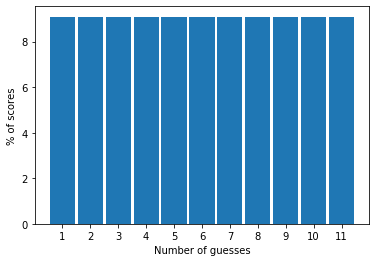

In [29]:
t = report_minimizing_tree(max, ails)

But an inconsistent guesser can make a guesses that more evenly partition the remaining words, giving an average of only 4 guesses, and a worst case of 5 guesses: 

minimizing the max of partition sizes over 11 targets in a 2,845 word list,
including inconsistent words.
first guess: "front"
median: 4 guesses, mean: 4.00 ± 0.77, worst: 5, scores: 11
cumulative: ≤3:27%, ≤4:73%, ≤5:100%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%


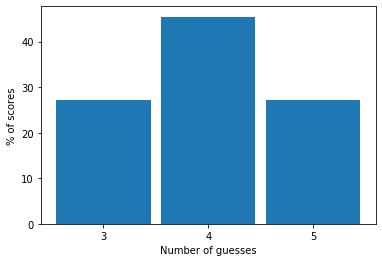

In [30]:
t = report_minimizing_tree(max, ails, inconsistent=True)

# Reports on Consistent  Guessers

Here are reports on trees made from minimizing the three metrics, with only consistent guesses allowed: 

minimizing the max of partition sizes over 2,845 targets in a 2,845 word list,
not including inconsistent words.
first guess: "wader"
median: 7 guesses, mean: 7.15 ± 1.81, worst: 18, scores: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:13%, ≤6:35%, ≤7:67%, ≤8:86%, ≤9:92%, ≤10:95%
CPU times: user 6.73 s, sys: 11.3 ms, total: 6.74 s
Wall time: 6.75 s


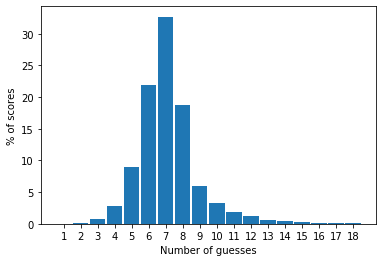

In [31]:
%time t = report_minimizing_tree(max, inconsistent=False)

minimizing the expectation of partition sizes over 2,845 targets in a 2,845 word list,
not including inconsistent words.
first guess: "raved"
median: 7 guesses, mean: 7.14 ± 1.82, worst: 17, scores: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:13%, ≤6:36%, ≤7:68%, ≤8:85%, ≤9:91%, ≤10:95%
CPU times: user 6.43 s, sys: 5.51 ms, total: 6.44 s
Wall time: 6.44 s


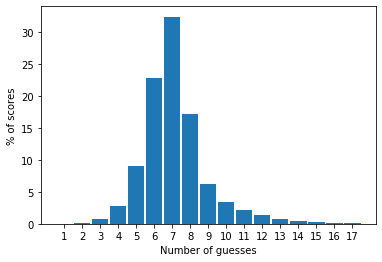

In [32]:
%time t = report_minimizing_tree(expectation, inconsistent=False)

minimizing the neg_entropy of partition sizes over 2,845 targets in a 2,845 word list,
not including inconsistent words.
first guess: "debar"
median: 7 guesses, mean: 7.09 ± 1.78, worst: 19, scores: 2,845
cumulative: ≤3:1%, ≤4:4%, ≤5:13%, ≤6:36%, ≤7:69%, ≤8:86%, ≤9:92%, ≤10:96%
CPU times: user 6.45 s, sys: 6.68 ms, total: 6.46 s
Wall time: 6.46 s


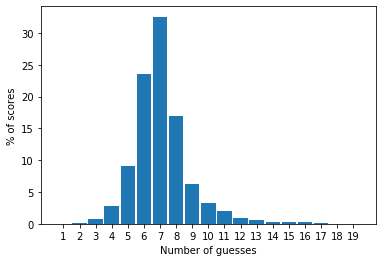

In [33]:
%time t = report_minimizing_tree(neg_entropy, inconsistent=False)

The random guesser can also be classified as a consistent guesser. Here is a report on it:|

median: 7 guesses, mean: 7.42 ± 1.71, worst: 17, scores: 2,845
cumulative: ≤3:1%, ≤4:3%, ≤5:11%, ≤6:28%, ≤7:55%, ≤8:77%, ≤9:91%, ≤10:96%
CPU times: user 6.57 s, sys: 9.57 ms, total: 6.58 s
Wall time: 6.58 s


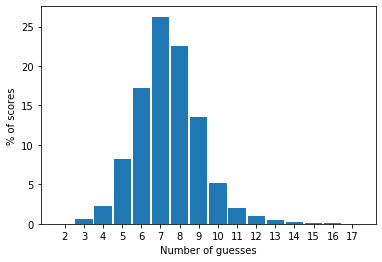

In [34]:
%time report(play(random_guesser, target, wordlist, verbose=False) for target in wordlist)

The random consistent guesser strategy might have seemed hopelessly naive, but it is actually a pretty decent strategy, with mean number of guesses only 5% worse than the best minimizing tree. 

# Reports on Inconsistent  Guessers
Now we'll report on trees with inconsistent guesses allowed. This will take longer; about 30 seconds per tree.

minimizing the max of partition sizes over 2,845 targets in a 2,845 word list,
including inconsistent words.
first guess: "wader"
median: 7 guesses, mean: 7.05 ± 0.98, worst: 10, scores: 2,845
cumulative: ≤3:0%, ≤4:1%, ≤5:6%, ≤6:24%, ≤7:69%, ≤8:95%, ≤9:99.9%, ≤10:100%
CPU times: user 25.9 s, sys: 17.6 ms, total: 25.9 s
Wall time: 25.9 s


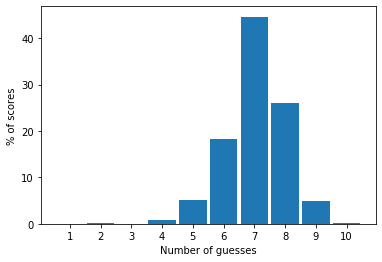

In [35]:
%time t = report_minimizing_tree(max, inconsistent=True)

minimizing the expectation of partition sizes over 2,845 targets in a 2,845 word list,
including inconsistent words.
first guess: "raved"
median: 7 guesses, mean: 6.84 ± 0.95, worst: 10, scores: 2,845
cumulative: ≤3:0%, ≤4:1%, ≤5:7%, ≤6:32%, ≤7:78%, ≤8:97%, ≤9:100.0%, ≤10:100%
CPU times: user 26.3 s, sys: 19.1 ms, total: 26.3 s
Wall time: 26.3 s


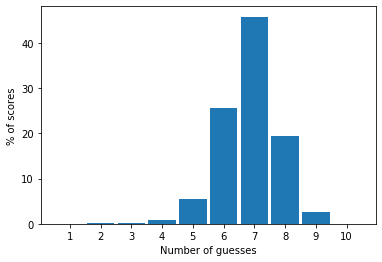

In [36]:
%time t = report_minimizing_tree(expectation, inconsistent=True)

minimizing the neg_entropy of partition sizes over 2,845 targets in a 2,845 word list,
including inconsistent words.
first guess: "debar"
median: 7 guesses, mean: 6.82 ± 1.00, worst: 10, scores: 2,845
cumulative: ≤3:0%, ≤4:1%, ≤5:8%, ≤6:35%, ≤7:78%, ≤8:97%, ≤9:99.6%, ≤10:100%
CPU times: user 27.1 s, sys: 24.7 ms, total: 27.2 s
Wall time: 27.2 s


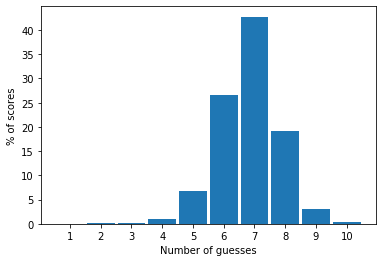

In [37]:
%time t = report_minimizing_tree(neg_entropy, inconsistent=True)

# Report Summary

Here's a table of the mean and maximum number of guesses for the seven approaches:

|<br><u>2,845 words</u><br>Algorithm|Consistent<br><u>Only</u><br>Mean (Max)|Inconsistent<br><u>Allowed</u><br>Mean (Max)|
|--|--|--|
|random guesser|7.42 (17)|  |
|minimize max|7.15 (18)|7.05 (10)|
|minimize expectation|7.14 (17)|6.84 (10)|
|minimize neg_entropy|7.09 (19)|6.82 (10)|


# Wordle

[Wordle](https://www.powerlanguage.co.uk/wordle/) is a [suddenly-popular](https://www.nytimes.com/2022/01/03/technology/wordle-word-game-creator.html) variant of Jotto (with a little Mastermind thrown in) with these differences:
- Words with repeated letters are allowed (e.g. `'aback'`).
- Anagrams are allowed (e.g. `'arise'` and `'raise'`).
- The reply to a guess consists of 5 pieces ([trits](https://en.wiktionary.org/wiki/trit#English)) of information, one for each position in the guess:
  - *Green* if the guess letter is in the correct spot.
  - *Yellow* if the guess letter is in the word but in the wrong spot.
  - *Miss* if the letter is not in the word in any spot.
- Wordle uses a larger list of 12,971 allowable guess words, but only 2,315 of them can be target words. (I think the idea is to follow [Postel's law](https://en.wikipedia.org/wiki/Robustness_principle) to avoid annoying a player: be conservative in the targets (so that a player is very likely to be familiar with the target word) and be liberal in accepting guess words.)
  
There is an ambiguity in the rules. Assume the guess is *etude* and the target is *poems*. A strict reading of the rules would say they both *e* positions should be *yellow*, because both instances of *e* are "in the word but in the wrong spot." But it seems Wordle actually reports the first *e* as yellow and the second *e* as a miss.

In [38]:
wordle_small = read_words('wordle-small.txt') #  2,315 target words
wordle_big   = read_words('wordle-big.txt')   # 12,971 guess  words

Green, Yellow, Miss = 'GY.' # A Wordle reply is 5 characters, each one of 'GY.'

def wordle_reply_for(guess, target) -> str: 
    "The five-character reply for this guess on this target in Wordle."
    # We'll start by having each reply be either Green or Miss ...
    reply = [Green if guess[i] == target[i] else Miss for i in range(5)]
    # ... then we'll change the replies that should be yellow
    counts = Counter(target[i] for i in range(5) if guess[i] != target[i])
    for i in range(5):
        if reply[i] == Miss and counts[guess[i]] > 0:
            counts[guess[i]] -= 1
            reply[i] = Yellow
    return ''.join(reply)

The right thing to do now would be to refactor the code to allow for the injection of a different `reply_for` function, so that either game could be played at any time.

However, I'm going to take a shortcut: I'm going to require the programmer to call `setup` with the name of the game they want, `'jotto'` or `'wordle'`. It will set global variables accordingly. I'll also require the programmer to use the right word list and target words.

In [39]:
jotto_reply_for = reply_for

In [40]:
def setup(game: str) -> None:
    "Set global variables to play either 'jotto' or 'wordle'."
    global reply_for, inconsistent_max
    if game == 'jotto':
        reply_for = jotto_reply_for
        inconsistent_max = 400
    elif game == 'wordle':
        reply_for = wordle_reply_for
        inconsistent_max = 125
    else:
        raise ValueError(f'unknown game: {game}')

In [41]:
setup('wordle')

Note that in Jotto, `reply_for` was symmetric; `reply_for(g, t) == reply_for(t, g)`. But that is not true for Wordle.  I made some tests for `wordle_reply_for` to give me some confidence I got it right:

In [42]:
assert reply_for('treat', 'truss') == 'GG...'  and  reply_for('truss', 'treat') == 'GG...'
assert reply_for('stars', 'traps') == '.YGYG'  and  reply_for('traps', 'stars') == 'YYG.G'
assert reply_for('palls', 'splat') == 'YYG.Y'  and  reply_for('splat', 'palls') == 'YYGY.'
assert reply_for('banal', 'apple') == '.Y..Y'  and  reply_for('apple', 'banal') == 'Y..Y.'
assert reply_for('banal', 'mania') == '.GGY.'  and  reply_for('mania', 'banal') == '.GG.Y'
assert reply_for('epees', 'geese') == 'Y.GYY'  and  reply_for('geese', 'epees') == '.YGYY'
assert reply_for('wheee', 'peeve') == '..GYG'  and  reply_for('peeve', 'wheee') == '.YG.G'

We can test the new `reply_for` on a partition of `words22`:

In [43]:
partition('write', words22)

defaultdict(list,
            {'.YYYY': ['their'],
             '...Y.': ['about'],
             'G....': ['would'],
             '.Y.YG': ['throe'],
             'YY...': ['sword'],
             '.....': ['cloud', 'sound', 'fondu'],
             'GGGGG': ['write'],
             '.YYG.': ['rifts', 'girth'],
             'GY.YY': ['water'],
             '.Y.YY': ['after'],
             '..GY.': ['think'],
             '.Y..Y': ['resay', 'nuder'],
             '....G': ['place', 'house'],
             '.G.GG': ['grate'],
             '...YY': ['ethos'],
             '..YY.': ['might'],
             'G.G.G': ['while']})

That looks good. Notice that there are many more possible replies in Wordle than the 6 possible replies in Jotto, so the target words are partitioned into smaller branches. It should take fewer guesses to solve a Wordle than a Jotto. How many possible replies are there? There are 3 responses at each of five positions, and  3<sup>5</sup> = 243, but five of those replies are impossible: you can't have four Greens and one Yellow, because if four letters of the guess are in the right place then the fifth must be either in the right place or a miss. 

# Sample Wordle Games

Let's see what some Wordle games look like, using a random guesser:

In [44]:
play(random_guesser, wordlist=wordle_small)

Guess 1: "pluck" Reply: .Y...; Consistent targets: 269
Guess 2: "false" Reply: ..G.Y; Consistent targets: 9
Guess 3: "below" Reply: GGGGG; Consistent targets: 1


3

In [45]:
play(random_guesser, wordlist=wordle_small)

Guess 1: "caddy" Reply: .....; Consistent targets: 729
Guess 2: "rupee" Reply: Y....; Consistent targets: 62
Guess 3: "snort" Reply: G.GGY; Consistent targets: 2
Guess 4: "stork" Reply: GGGG.; Consistent targets: 1
Guess 5: "storm" Reply: GGGGG; Consistent targets: 1


5

In [46]:
play(random_guesser, wordlist=wordle_small)

Guess 1: "wiser" Reply: .G...; Consistent targets: 73
Guess 2: "ninth" Reply: .GG..; Consistent targets: 9
Guess 3: "final" Reply: .GG.G; Consistent targets: 1
Guess 4: "vinyl" Reply: GGGGG; Consistent targets: 1


4

# Reports on Wordle Guessers

Wordle has about the same number of target words as Jotto, but many more guess words, and the `wordle_reply_for` computation is more complex, so computations take longer (more so for the inconsistent guessers). Here are reports on the seven strategies:

median: 4 guesses, mean: 4.10 ± 1.04, worst: 8, scores: 2,315
cumulative: ≤3:28%, ≤4:69%, ≤5:92%, ≤6:98%, ≤7:99.4%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 30.1 s, sys: 29.3 ms, total: 30.1 s
Wall time: 30.2 s


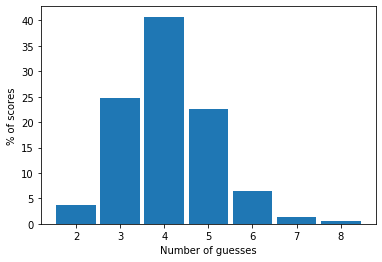

In [47]:
%time report(play(random_guesser, target, wordle_small, verbose=False) for target in wordle_small)

minimizing the max of partition sizes over 2,315 targets in a 12,971 word list,
not including inconsistent words.
first guess: "arise"
median: 4 guesses, mean: 3.68 ± 0.86, worst: 8, scores: 2,315
cumulative: ≤3:43%, ≤4:87%, ≤5:97%, ≤6:99.4%, ≤7:99.9%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 29 s, sys: 36.4 ms, total: 29 s
Wall time: 29 s


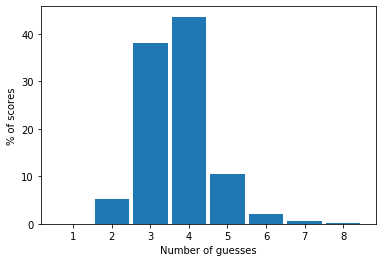

In [48]:
%time t = report_minimizing_tree(max, wordle_small, wordle_big, inconsistent=False)

minimizing the expectation of partition sizes over 2,315 targets in a 12,971 word list,
not including inconsistent words.
first guess: "raise"
median: 4 guesses, mean: 3.62 ± 0.86, worst: 8, scores: 2,315
cumulative: ≤3:47%, ≤4:88%, ≤5:98%, ≤6:99.4%, ≤7:99.9%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 29.2 s, sys: 25.8 ms, total: 29.2 s
Wall time: 29.2 s


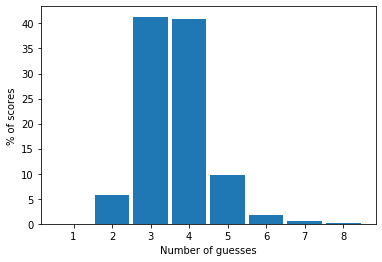

In [49]:
%time t = report_minimizing_tree(expectation, wordle_small, wordle_big, inconsistent=False)

minimizing the neg_entropy of partition sizes over 2,315 targets in a 12,971 word list,
not including inconsistent words.
first guess: "raise"
median: 4 guesses, mean: 3.60 ± 0.85, worst: 8, scores: 2,315
cumulative: ≤3:49%, ≤4:89%, ≤5:97%, ≤6:99.5%, ≤7:99.9%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 29.1 s, sys: 25.4 ms, total: 29.2 s
Wall time: 29.2 s


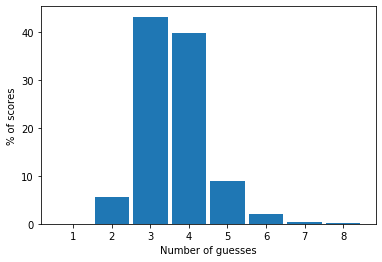

In [50]:
%time t = report_minimizing_tree(neg_entropy, wordle_small, wordle_big, inconsistent=False)

The **inconsistent guessers** will each take about 4 minutes to compute:

minimizing the max of partition sizes over 2,315 targets in a 12,971 word list,
including inconsistent words.
first guess: "arise"
median: 4 guesses, mean: 3.62 ± 0.64, worst: 6, scores: 2,315
cumulative: ≤3:42%, ≤4:94%, ≤5:99.7%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 4min 3s, sys: 193 ms, total: 4min 3s
Wall time: 4min 7s


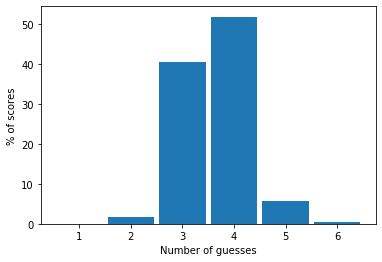

In [51]:
%time t = report_minimizing_tree(max, wordle_small, wordle_big, inconsistent=True)

minimizing the expectation of partition sizes over 2,315 targets in a 12,971 word list,
including inconsistent words.
first guess: "raise"
median: 4 guesses, mean: 3.52 ± 0.62, worst: 6, scores: 2,315
cumulative: ≤3:50%, ≤4:96%, ≤5:99.8%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 4min 47s, sys: 144 ms, total: 4min 47s
Wall time: 4min 58s


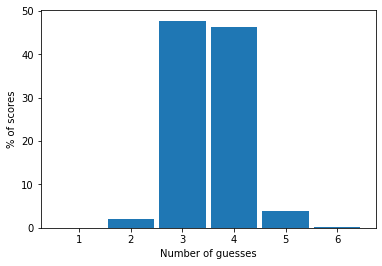

In [52]:
%time t = report_minimizing_tree(expectation, wordle_small, wordle_big, inconsistent=True)

minimizing the neg_entropy of partition sizes over 2,315 targets in a 12,971 word list,
including inconsistent words.
first guess: "raise"
median: 3 guesses, mean: 3.50 ± 0.62, worst: 6, scores: 2,315
cumulative: ≤3:52%, ≤4:96%, ≤5:99.7%, ≤6:100%, ≤7:100%, ≤8:100%, ≤9:100%, ≤10:100%
CPU times: user 4min 26s, sys: 147 ms, total: 4min 26s
Wall time: 4min 34s


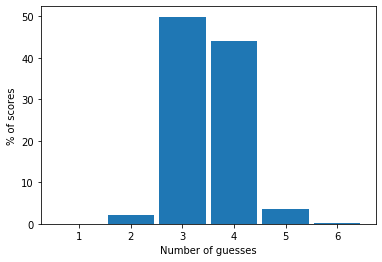

In [53]:
%time t = report_minimizing_tree(neg_entropy, wordle_small, wordle_big, inconsistent=True)

**Mission accomplished!** All three metrics solve every target word in 6 guesses or less. 

# Jotto and Wordle Evaluation Summary

Here is a summary of the reports on both games:

|<br><br><br>Algorithm|JOTTO<br>Consistent<br><u>Only</u><br>Mean (Max)|JOTTO<br>Inconsistent<br><u>Allowed</u><br>Mean (Max)|WORDLE<br>Consistent<br><u>Only</u><br>Mean (Max)|WORDLE<br>Inconsistent<br><u>Allowed</u><br>Mean (Max)||
|--|--|--|--|--|--|
|random guesser|7.34 (18)|  |4.10 (8) |   |
|minimize max|7.15 (18)|7.05 (10)| 3.68 (8) | 3.62 (6) | 
|minimize expectation|7.14 (17)|6.84 (10)| 3.62 (8) | 3.52 (6) | 
|minimize neg_entropy|7.09 (19)|6.82 (10)| 3.60 (8) |  3.50 (6) |


# Sample Wordle Games with Minimizing Guesser

Here are some sample games with the negative-entropy minimizing, inconsistent-guessing guesser:

In [54]:
for target in random.sample(wordle_small, 5):
    play(TreeGuesser(t), target, wordle_big)
    print()

Guess 1: "raise" Reply: ...YY; Consistent targets: 797
Guess 2: "spelt" Reply: G.GG.; Consistent targets: 11
Guess 3: "fehme" Reply: .Y...; Consistent targets: 3
Guess 4: "swell" Reply: GGGGG; Consistent targets: 1

Guess 1: "raise" Reply: YY...; Consistent targets: 297
Guess 2: "tronc" Reply: .G..Y; Consistent targets: 12
Guess 3: "calmy" Reply: GY..G; Consistent targets: 2
Guess 4: "crazy" Reply: GGGGG; Consistent targets: 1

Guess 1: "raise" Reply: YY...; Consistent targets: 297
Guess 2: "tronc" Reply: .GY..; Consistent targets: 8
Guess 3: "abram" Reply: G.G..; Consistent targets: 2
Guess 4: "arrow" Reply: GGGGG; Consistent targets: 1

Guess 1: "raise" Reply: Y.G..; Consistent targets: 75
Guess 2: "crypt" Reply: .G.Y.; Consistent targets: 7
Guess 3: "primo" Reply: GGGGG; Consistent targets: 1

Guess 1: "raise" Reply: ..YY.; Consistent targets: 343
Guess 2: "shout" Reply: Y.Y..; Consistent targets: 46
Guess 3: "bison" Reply: .GGY.; Consistent targets: 6
Guess 4: "disco" Reply: GGGGG;

# Best and Worst First Guess Words

Here's a function to create a table of the best and worst first guesses in a game (that is, the highest and lowest scoring words on the partition counts), according to each of the three metrics:

In [55]:
import pandas as pd

def first_guesses(targets, wordlist) -> pd.DataFrame: 
    """A data frame of words and scores on the 3 metrics, sorted best to worst."""
    metrics = (max, expectation, neg_entropy)
    data = [sorted((metric(partition_counts(g, targets)), g) for g in wordlist)
            for metric in metrics]
    def reformat(row):
        (val1, word1), (val2, word2), (val3, word3) = row
        return [word1, val1, word2, round(val2, 2), word3, round(val3, 3)]
    return pd.DataFrame(map(reformat, zip(*data)), 
                        columns='max_word max exp_word exp ent_word ent'.split())

The best and worst first guesses for **Jotto**:

In [56]:
setup('jotto')
%time df = first_guesses(wordlist, wordlist)
df

CPU times: user 13.9 s, sys: 7.46 ms, total: 13.9 s
Wall time: 13.9 s


,max_word,max,exp_word,exp,ent_word,ent
0,wader,1012,raved,812.84,debar,-1.949
1,cadre,1026,debar,818.32,alder,-1.946
2,armed,1028,roved,826.51,raved,-1.944
3,diner,1029,orbed,826.71,dater,-1.943
4,coder,1030,wader,827.04,cadre,-1.943
...,...,...,...,...,...,...
2840,coqui,1535,okapi,1105.28,jumpy,-1.575
2841,quota,1548,azoic,1120.19,juicy,-1.566
2842,azoic,1555,axiom,1157.49,axiom,-1.563
2843,axiom,1615,audio,1184.28,audio,-1.494


The top guesses  favor the letters "a", "d", "e", and "r". 

The word "ouija" is a uniquely terrible guess; mostly what it does is confirm that a majority of the words have exactly one of the vowels "aiou". The output above only shows the top 5 guesses; here are the top 20:

In [57]:
df[:20]

,max_word,max,exp_word,exp,ent_word,ent
0,wader,1012,raved,812.84,debar,-1.949
1,cadre,1026,debar,818.32,alder,-1.946
2,armed,1028,roved,826.51,raved,-1.944
3,diner,1029,orbed,826.71,dater,-1.943
4,coder,1030,wader,827.04,cadre,-1.943
5,padre,1035,armed,827.28,armed,-1.939
6,raved,1038,fader,828.28,garde,-1.938
7,rayed,1038,dater,829.41,wader,-1.938
8,delta,1039,alder,829.96,lased,-1.935
9,drone,1041,cadre,829.98,padre,-1.934


The best and worst first guesses for **Wordle**:

In [58]:
setup('wordle')
%time df2 = first_guesses(wordle_small, wordle_big)
df2

CPU times: user 9min 17s, sys: 291 ms, total: 9min 17s
Wall time: 9min 36s


,max_word,max,exp_word,exp,ent_word,ent
0,aesir,168,roate,60.42,soare,-5.886
1,arise,168,raise,61.00,roate,-5.883
2,raise,168,raile,61.33,raise,-5.878
3,reais,168,soare,62.30,raile,-5.866
4,serai,168,arise,63.73,reast,-5.865
...,...,...,...,...,...,...
12966,susus,1369,gyppy,885.90,yukky,-2.205
12967,fuffy,1374,jugum,900.61,xylyl,-2.192
12968,gyppy,1380,jujus,903.31,immix,-2.053
12969,jugum,1410,qajaq,925.11,jujus,-2.038


Again, the best words use popular letters. One difference is that in Jotto, the best guesses have two vowels, in Wordle three. The worst words have repeated unpopular letters, like "qajaq" and "yukky". Here are the top 20 guesses:

In [59]:
df2[:20]

,max_word,max,exp_word,exp,ent_word,ent
0,aesir,168,roate,60.42,soare,-5.886
1,arise,168,raise,61.00,roate,-5.883
2,raise,168,raile,61.33,raise,-5.878
3,reais,168,soare,62.30,raile,-5.866
4,serai,168,arise,63.73,reast,-5.865
5,aiery,171,irate,63.78,slate,-5.856
6,ayrie,171,orate,63.89,crate,-5.835
7,ariel,173,ariel,65.29,salet,-5.835
8,raile,173,arose,66.02,irate,-5.831
9,aloes,174,raine,67.06,trace,-5.831


# Next Steps

There are many directions you could take this if you are interested:
- **Other games:**
  - Consider a Jotto game variant where each reply consists of two numbers: the number of letters in common with the target, and the number of letters that are in the exact correct position (as in Mastermind).
  - Implement [Mastermind](https://en.wikipedia.org/wiki/Mastermind_%28board_game%29). The default version has 6 colors and 4 pegs. Can you go beyond that?
  - Research what other computer scientists have done with [Jotto](https://arxiv.org/abs/1107.3342) or [Mastermind](http://serkangur.freeservers.com/).
  - Refactor the code so it can smoothly handle multiple different games.
- **Better strategy**:
  - Our `minimizing_tree` function is **greedy** in that it guesses the word that minimizes some metric of the current situation without looking ahead to future branches in the tree. Can you get better performance by doing some **look-ahead**? Perhaps with a beam search?
  - As an alternative to look-ahead, can you improve a tree by editing it? Given a tree, look for interior nodes that end up with a worse-than-expected average score, and see if the node can be replaced with something better (covering the same target words). Correcting a few bad nodes might be faster than carefully searching for good nodes in the first place.
  - The three metrics (max, expectation, and negative entropy) are all designed as proxies to what we really want to minimize: the average number of guesses. Can we estimate that directly? For example, we know a branch of size 1 will always take 1 guess; of size 2 an average of 3/2 guesses; and of size 3 an average of 5/3 guesses if one of the words partitions the other two, otherwise an average of 2. Can we learn a function that takes a set of words as input and estimates the average number of guesses for the set? Would a deep neural net be a good way to learn this function?
  - Is it feasible to do a complete search and find the guaranteed optimal strategy? What optimizations to the code would be necessary? How long would the search take?
- **Chooser strategy**:
  - Analyze the game where the chooser is not random, but rather is an adversary to the guesser–the chooser tries to choose a word that will maximize the guesser's score. What's a good strategy for the chooser? Is there a strategy equilibrium?
  - Refactor `play` to accomodate three roles:
    - A chooser, who decides what the target word is.
    - A guesser, who guesses the target word.
    - A replier, who says what the reply to the guess is.